#### Loading of required libraries

In [2]:
## The below code shows the generic way of building the Linear Regression model and to check the error metrics

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

#### Data loading

In [4]:
data = pd.read_csv(r'train_(2)_(1).csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10656 entries, 0 to 10655
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            10656 non-null  int64  
 1   area_type     10656 non-null  object 
 2   availability  10656 non-null  object 
 3   location      10655 non-null  object 
 4   size          10642 non-null  object 
 5   society       6228 non-null   object 
 6   total_sqft    10656 non-null  object 
 7   bath          10591 non-null  float64
 8   balcony       10152 non-null  float64
 9   price         10656 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 832.6+ KB


In [6]:
data.shape

(10656, 10)

In [7]:
data.head(2)

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00


#### Data pre-processing Data Cleaning

In [8]:
# checking missing values
data.isnull().sum()

ID                 0
area_type          0
availability       0
location           1
size              14
society         4428
total_sqft         0
bath              65
balcony          504
price              0
dtype: int64

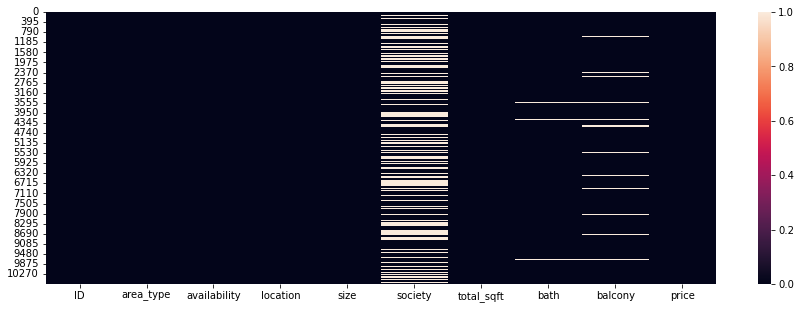

In [9]:
plt.figure(figsize = [15,5])
sns.heatmap(data.isnull())
plt.show()

In [10]:
# Define conversion factors
conversion_factors = {
    'Sq. Meter': 10.7639,  # 1 Sq. Meter = 10.7639 Sq. Ft
    'Sq. Yards': 9,        # 1 Sq. Yard = 9 Sq. Ft
    'Acres': 43560,        # 1 Acre = 43560 Sq. Ft
    'Guntha': 1089,        # 1 Guntha = 1089 Sq. Ft
    'Cents': 435.6,        # 1 Cent = 435.6 Sq. Ft
    'Perch': 272.25,       # 1 Perch = 272.25 Sq. Ft
    'Grounds': 2400        # 1 Ground = 2400 Sq. Ft
}

# Function to convert to Sq Ft
def convert_to_sq_ft(value):
    try:
        if any(unit in value for unit in conversion_factors):   # Check if the value has a unit or is numeric
            for unit in conversion_factors:                     # Split the numeric part and the unit
                if unit in value:
                    number = float(value.replace(unit, '').strip())
                    return number * conversion_factors[unit]     # Convert using the factor
        else:                                                    # If no unit is specified, assume the value is already in Sq Ft
            return float(value)
    except (ValueError, KeyError):
        return value                                              # Return the original value if conversion fails



In [11]:
def mean_for_range(df):
    ind = df.index
    for i in ind:
        if '-' in df.loc[i, 'total_sqft']:
            t = df.loc[i]['total_sqft'].split(sep='-')
            df.at[i ,'total_sqft_converted'] = (float(t[0]) + float(t[1]))/2
    return df



In [12]:
# We have observed that there are missing values in the dataset 
# Within the Data_pre_processing we handling the missing values

def Data_pre_processing(data):
    # dropping the unnecessary columns
    data.drop(columns = ['ID','society','availability'] ,axis = 1 , inplace = True)
    
    # dropping null values
    data.dropna(subset= ['size','location','bath'],inplace = True)
    
    # data imputation for null values
    data['balcony'].fillna(data['balcony'].mode()[0], inplace=True)
    
    data['size'] = data['size'].str.extract(r'(\d+)')

    # converting to int
    data['size'] = data['size'].astype('int')

    data['total_sqft_converted'] = data['total_sqft'].apply(convert_to_sq_ft)
    data = mean_for_range(data)
    data['total_sqft_converted'] = data['total_sqft_converted'].astype(float)

    #dropping 'total_sqft' since total_sqft_converted is created
    data.drop(columns = 'total_sqft',axis = 1,inplace = True)

    # standardising the 'location' filed
    data['location'] = data['location'].str.strip().str.upper()
    
    return data
    

In [13]:
def outlier_treatment(data):
    for i in data.columns:
        q1 = data[i].quantile(0.25)
        q3 = data[i].quantile(0.75)
        IQR = q3 - q1
        lb = q1 - 1.5 * IQR  # Lower bound
        ub = q3 + 1.5 * IQR  # Upper bound

        # Define 10th and 90th percentiles
        quantile_10 = data[i].quantile(0.10)
        quantile_90 = data[i].quantile(0.90)

        data[i] = np.where(data[i] < lb, quantile_10, data[i])
        data[i] = np.where(data[i] > ub, quantile_90, data[i])

    return data

##### Calling function to perform data pre-process and outlier treatment

In [14]:
data = Data_pre_processing(data)

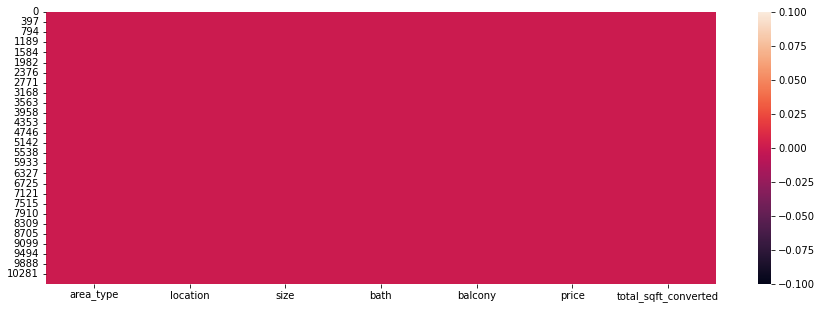

In [15]:
plt.figure(figsize = [15,5])
sns.heatmap(data.isnull())
plt.show()

In [16]:
data_num1 = data.select_dtypes(include = np.number)
data_cat1 = data.select_dtypes(include = object)

data_num1 = outlier_treatment(data_num1)

# combining categorical and numerical column
data = pd.concat([data_cat1, data_num1],axis = 1)

In [17]:
data.shape

(10590, 7)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10590 entries, 0 to 10655
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   area_type             10590 non-null  object 
 1   location              10590 non-null  object 
 2   size                  10590 non-null  float64
 3   bath                  10590 non-null  float64
 4   balcony               10590 non-null  float64
 5   price                 10590 non-null  float64
 6   total_sqft_converted  10590 non-null  float64
dtypes: float64(5), object(2)
memory usage: 919.9+ KB


In [19]:
data

,area_type,location,size,bath,balcony,price,total_sqft_converted
0,Super built-up Area,ELECTRONIC CITY PHASE II,2.0,2.0,1.0,39.07,1056.0
1,Plot Area,CHIKKA TIRUPATHI,4.0,4.0,3.0,120.00,2425.0
2,Built-up Area,UTTARAHALLI,3.0,2.0,3.0,62.00,1440.0
3,Super built-up Area,LINGADHEERANAHALLI,3.0,3.0,1.0,95.00,1521.0
4,Super built-up Area,KOTHANUR,2.0,2.0,1.0,51.00,1200.0
...,...,...,...,...,...,...,...
10651,Plot Area,PARAPPANA AGRAHARA,1.0,1.0,0.0,45.00,1200.0
10652,Super built-up Area,BHOGANHALLI,2.0,2.0,1.0,69.90,1260.0
10653,Super built-up Area,DODDANAKUNDI INDUSTRIAL AREA 2,2.0,2.0,1.0,49.00,1092.0
10654,Super built-up Area,KACHANAYAKANAHALLI,2.0,2.0,0.0,34.00,827.0


#### encoding area_type column

In [20]:
encoder = OneHotEncoder(sparse=True)
area_enc = encoder.fit_transform(data[['area_type']]).toarray()

# convert Sparce matrix to dataframe
df_area_enc = pd.DataFrame(area_enc ,columns = encoder.get_feature_names_out()).reset_index(drop=True)

# concatenate the encoded dataframe with original df along column
#data = pd.concat([data,df_area_enc],axis = 1).reset_index(drop=True)

In [21]:
print(data.shape)          # Should be (10590, 7)
print(df_area_enc.shape)

(10590, 7)
(10590, 4)


In [22]:
data.reset_index(drop=True, inplace=True)
df_area_enc.reset_index(drop=True, inplace=True)

In [23]:
data = pd.concat([data, df_area_enc], axis=1)

In [24]:
data.shape

(10590, 11)

#### Frequency encoding on location

In [25]:
# grouping by frequency
fq = data.groupby('location').size()/len(data)

# mapping values to dataframe
data.loc[:, "{}_freq_encode".format('location')] = data['location'].map(fq)

In [26]:
data.shape

(10590, 12)

In [27]:
Y = data['price']
data = data.drop('price' , axis = 1)

#### Scaling the numeric columns

In [28]:
data.dtypes

area_type                          object
location                           object
size                              float64
bath                              float64
balcony                           float64
total_sqft_converted              float64
area_type_Built-up  Area          float64
area_type_Carpet  Area            float64
area_type_Plot  Area              float64
area_type_Super built-up  Area    float64
location_freq_encode              float64
dtype: object

In [29]:
# dropping the original columns after doing encoding
data.drop(columns=['area_type','location'],axis=1,inplace = True)

In [30]:
data

,size,bath,balcony,total_sqft_converted,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,location_freq_encode
0,2.0,2.0,1.0,1056.0,0.0,0.0,0.0,1.0,0.009348
1,4.0,4.0,3.0,2425.0,0.0,0.0,1.0,0.0,0.001228
2,3.0,2.0,3.0,1440.0,1.0,0.0,0.0,0.0,0.014353
3,3.0,3.0,1.0,1521.0,0.0,0.0,0.0,1.0,0.001700
4,2.0,2.0,1.0,1200.0,0.0,0.0,0.0,1.0,0.004060
...,...,...,...,...,...,...,...,...,...
10585,1.0,1.0,0.0,1200.0,0.0,0.0,1.0,0.0,0.001039
10586,2.0,2.0,1.0,1260.0,0.0,0.0,0.0,1.0,0.003777
10587,2.0,2.0,1.0,1092.0,0.0,0.0,0.0,1.0,0.000283
10588,2.0,2.0,0.0,827.0,0.0,0.0,0.0,1.0,0.000283


In [31]:
data.columns

Index(['size', 'bath', 'balcony', 'total_sqft_converted',
       'area_type_Built-up  Area', 'area_type_Carpet  Area',
       'area_type_Plot  Area', 'area_type_Super built-up  Area',
       'location_freq_encode'],
      dtype='object')

In [32]:
df_num = data[['size', 'bath', 'balcony', 'total_sqft_converted']]

# Select categorical columns (encoded area_type columns and location_freq_encode)
df_cat = data[['area_type_Built-up  Area', 'area_type_Carpet  Area',
       'area_type_Plot  Area', 'area_type_Super built-up  Area',
       'location_freq_encode']]

In [33]:
# scaling on numberic columns
sc = StandardScaler()
data_sc = sc.fit_transform(df_num)
data_sc = pd.DataFrame(data_sc , columns = df_num.columns)

#data_sc = pd.concat([d_cat , data_sc] ,axis = 1)

In [34]:
data_sc.shape

(10590, 4)

In [35]:
data_sc = pd.concat([df_cat , data_sc] ,axis = 1)

In [36]:
data_sc

,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,location_freq_encode,size,bath,balcony,total_sqft_converted
0,0.0,0.0,0.0,1.0,0.009348,-0.797629,-0.626039,-0.74099,-0.712389
1,0.0,0.0,1.0,0.0,0.001228,1.655011,1.743424,1.73287,1.992027
2,1.0,0.0,0.0,0.0,0.014353,0.428691,-0.626039,1.73287,0.046191
3,0.0,0.0,0.0,1.0,0.001700,0.428691,0.558692,-0.74099,0.206204
4,0.0,0.0,0.0,1.0,0.004060,-0.797629,-0.626039,-0.74099,-0.427922
...,...,...,...,...,...,...,...,...,...
10585,0.0,0.0,1.0,0.0,0.001039,-2.023949,-1.810771,-1.97792,-0.427922
10586,0.0,0.0,0.0,1.0,0.003777,-0.797629,-0.626039,-0.74099,-0.309394
10587,0.0,0.0,0.0,1.0,0.000283,-0.797629,-0.626039,-0.74099,-0.641272
10588,0.0,0.0,0.0,1.0,0.000283,-0.797629,-0.626039,-1.97792,-1.164771


In [37]:
inp = data_sc  # features
out = Y        # target variable

# splitting the data to test and train data
x_train, x_test, y_train, y_test = train_test_split(inp, out, test_size=0.2, random_state=42)

In [38]:
## Building the model

lr = LinearRegression()
model_lr = lr.fit(x_train, y_train)
model_lr

LinearRegression()

#### Checking the error metrics

In [39]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))


lr_score = model_lr.score(x_test, y_test) # with all num var 0.7842744111909903
lr_rmse = rmse(y_test, model_lr.predict(x_test))
lr_score, lr_rmse

(0.7012266487887681, 32.12245373926256)

In [40]:
## prediction on X_test

y_pred = model_lr.predict(x_test)

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 23.326586771128426
Mean Squared Error (MSE): 1031.852034231063
Root Mean Squared Error (RMSE): 32.12245373926256
R-squared: 0.7012266487887681


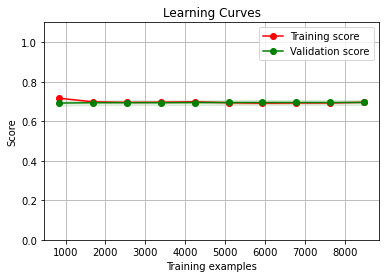

<Figure size 1440x1080 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(model_lr, inp, out, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation for training scores
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)

# Calculate mean and standard deviation for test scores
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Plot learning curves
plt.figure()
plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid()

# Plot the training score
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

# Plot the validation score
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")

plt.legend(loc="best")
plt.figure(figsize=[20,15])
plt.show()

In [43]:
from sklearn.model_selection import cross_val_score

cv_score = cross_val_score(model_lr , inp,out , cv = 5,scoring='neg_mean_squared_error')
cv_score

array([-1047.50248301, -1007.10917626, -1051.81214626, -1091.42781163,
       -1030.49070657])

In [44]:
mse , np.abs(cv_score.mean())

(1031.852034231063, 1045.668464747018)

In [45]:
### mse of the model and cv_score for different folds in not varying much

The cross-validation scores indicate that our model's performance is stable and consistent across different subsets of the data. The mean CV score being close to the original MSE is a good sign, showing that our model has good generalization ability.

#### Tuning hyperparameters

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Define the model
ridge = Ridge()

# Define the hyperparameters and their values
param_grid = {
    'alpha': [0.1, 0.2, 0.3,  0.5 , 0.8 , 1, 5 , 2,  10, 100],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

# Define the Grid Search
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", -best_score)


Best Parameters: {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Best Cross-Validation Score: 1049.5823431182744


In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_grid_scv = grid_search.predict(x_test)

mae_gcv = mean_absolute_error(y_test, y_pred_grid_scv)
mse_gcv = mean_squared_error(y_test, y_pred_grid_scv)
rmse_gcv = np.sqrt(mse)
r2_gcv = r2_score(y_test, y_pred_grid_scv)

# Display the results
print(f"Mean Absolute Error (MAE): {mae_gcv}")
print(f"Mean Squared Error (MSE): {mse_gcv}")
print(f"Root Mean Squared Error (RMSE): {rmse_gcv}")
print(f"R-squared: {r2_gcv}")

Mean Absolute Error (MAE): 23.314130174592435
Mean Squared Error (MSE): 1031.774870629275
Root Mean Squared Error (RMSE): 32.12245373926256
R-squared: 0.7012489915541384


In [48]:
# to make use of the added benefit of hyperparameter optimization and potential robustness in different data scenarios
# I'm using Grid Search Model for making prediction

#### Prediction

In [49]:
test_data = pd.read_csv(r'test_(2)_(1).csv')

In [50]:
test_data_copy = test_data

In [51]:
# Define conversion factors
conversion_factors = {
    'Sq. Meter': 10.7639,  # 1 Sq. Meter = 10.7639 Sq. Ft
    'Sq. Yards': 9,        # 1 Sq. Yard = 9 Sq. Ft
    'Acres': 43560,        # 1 Acre = 43560 Sq. Ft
    'Guntha': 1089,        # 1 Guntha = 1089 Sq. Ft
    'Cents': 435.6,        # 1 Cent = 435.6 Sq. Ft
    'Perch': 272.25,       # 1 Perch = 272.25 Sq. Ft
    'Grounds': 2400        # 1 Ground = 2400 Sq. Ft
}

# Function to convert to Sq Ft
def convert_to_sq_ft(value):
    try:
        if any(unit in value for unit in conversion_factors):   # Check if the value has a unit or is numeric
            for unit in conversion_factors:                     # Split the numeric part and the unit
                if unit in value:
                    number = float(value.replace(unit, '').strip())
                    return number * conversion_factors[unit]     # Convert using the factor
        else:                                                    # If no unit is specified, assume the value is already in Sq Ft
            return float(value)
    except (ValueError, KeyError):
        return value                                              # Return the original value if conversion fails

def mean_for_range(df):
    ind = df.index
    for i in ind:
        if '-' in df.loc[i, 'total_sqft']:
            t = df.loc[i]['total_sqft'].split(sep='-')
            df.at[i ,'total_sqft_converted'] = (float(t[0]) + float(t[1]))/2
    return df

In [52]:
def Data_pre_processing(data):
    #data = value
    data.drop(columns = ['ID','society','availability'] ,axis = 1 , inplace = True)
    data.dropna(subset=['size','location','bath'],inplace = True)
    data['balcony'].fillna(data['balcony'].mode()[0], inplace=True)
    
    data['size'] = data['size'].str.extract(r'(\d+)')

    # converting to int
    data['size'] = data['size'].astype('int')

    data['total_sqft_converted'] = data['total_sqft'].apply(convert_to_sq_ft)
    data = mean_for_range(data)
    data['total_sqft_converted'] = data['total_sqft_converted'].astype(float)

    #dropping 'total_sqft' since total_sqft_converted is created
    data.drop(columns = 'total_sqft',axis = 1,inplace = True)

    # standardising the 'location' filed
    data['location'] = data['location'].str.strip().str.upper()
    
    return data

In [53]:
test_data = Data_pre_processing(test_data)

In [54]:
test_data.describe()

,size,bath,balcony,total_sqft_converted
count,2656.000000,2656.000000,2656.000000,2656.000000
mean,2.812123,2.700678,1.609563,1670.491355
std,1.226397,1.297112,0.789793,5213.766296
min,1.000000,1.000000,0.000000,60.000000
25%,2.000000,2.000000,1.000000,1114.500000
50%,3.000000,2.000000,2.000000,1290.000000
75%,3.000000,3.000000,2.000000,1681.750000
max,18.000000,18.000000,3.000000,261360.000000


#### encoding

In [55]:
# on area_type
encoder = OneHotEncoder(sparse=True)
area_enc = encoder.fit_transform(test_data[['area_type']]).toarray()

# convert Sparce matrix to dataframe
df_area_enc = pd.DataFrame(area_enc ,columns = encoder.get_feature_names_out()).reset_index(drop=True)


print(test_data.shape)         
print(df_area_enc.shape)


test_data.reset_index(drop=True, inplace=True)
df_area_enc.reset_index(drop=True, inplace=True)

test_data = pd.concat([test_data, df_area_enc], axis=1)

(2656, 6)
(2656, 4)


In [56]:
# frequency encoding on location
fq = test_data.groupby('location').size()/len(test_data)

# mapping values to dataframe
test_data.loc[:, "{}_freq_encode".format('location')] = test_data['location'].map(fq)

In [57]:
test_data.drop(columns=['area_type','location'],axis=1,inplace = True)

#### scaling

In [58]:
test_df_num = test_data[['size', 'bath', 'balcony', 'total_sqft_converted']]

# Select categorical columns (encoded area_type columns and location_freq_encode)
test_df_cat = test_data[['area_type_Built-up  Area', 'area_type_Carpet  Area',
       'area_type_Plot  Area', 'area_type_Super built-up  Area',
       'location_freq_encode']]

In [59]:
test_df_num.shape

(2656, 4)

In [60]:
sc = StandardScaler()
test_data_sc = sc.fit_transform(test_df_num)
test_data_sc = pd.DataFrame(test_data_sc , columns = test_df_num.columns)

In [61]:
test_data_sc = pd.concat([test_df_cat , test_data_sc] ,axis = 1)

In [62]:
y_pred_test_data = grid_search.predict(test_data_sc)

In [63]:
result = pd.DataFrame(y_pred_test_data)

In [64]:
result

,0
0,62.972298
1,77.269103
2,83.742179
3,80.065690
4,107.597769
...,...
2651,111.848137
2652,124.645182
2653,78.566263
2654,122.241588
